# Conduct a time history analysis of an inelastic SDOF

This example runs a time history analysis of an elastic and inelastic single degree-of-freedom (SDOF) system using
the o3seespy package making use of a zero length element and the ``o3.uniaxial_material.Steel01`` material.

The elastic solution is compared to a closed form solution from the ``eqsig`` python package.

Author: Maxim Millen


### Load inline plotting and auto-reload commands

In [10]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the libraries needed for the analysis

In [28]:
import matplotlib.pyplot as plt
import numpy as np
from eqsig import sdof  # Used to validate elastic response
import o3seespy as o3
import o3seespy.__about__
print('o3seespy version: ', o3seespy.__about__.__version__)


o3seespy version:  3.1.0.17


## Define a function for conducting inelastic SDOF analysis

In [20]:
def get_inelastic_response(mass, k, f_yield, motion, dt, xi=0.05, r_post=0.0):
    """
    Run seismic analysis of a nonlinear SDOF

    Parameters
    ----------
    mass: float
        SDOF mass
    k: float
        Spring stiffness
    f_yield: float
        Yield strength
    motion: array_like,
        Acceleration values
    dt: float, time step of acceleration values
    xi: damping ratio
    r_post: post-yield stiffness
    
    Returns
    -------
    outputs: dict
        Dictionary containing time series from analysis
    """
    osi = o3.OpenSeesInstance(ndm=2, state=0)

    # Establish nodes
    bot_node = o3.node.Node(osi, 0, 0)
    top_node = o3.node.Node(osi, 0, 0)

    # Fix bottom node
    o3.Fix3DOF(osi, top_node, o3.cc.FREE, o3.cc.FIXED, o3.cc.FIXED)
    o3.Fix3DOF(osi, bot_node, o3.cc.FIXED, o3.cc.FIXED, o3.cc.FIXED)
    # Set out-of-plane DOFs to be slaved
    o3.EqualDOF(osi, top_node, bot_node, [o3.cc.Y, o3.cc.ROTZ])

    # nodal mass (weight / g):
    o3.Mass(osi, top_node, mass, 0., 0.)

    # Define material
    bilinear_mat = o3.uniaxial_material.Steel01(osi, fy=f_yield, e0=k, b=r_post)

    # Assign zero length element, # Note: pass actual node and material objects into element
    o3.element.ZeroLength(osi, [bot_node, top_node], mats=[bilinear_mat], dirs=[o3.cc.DOF2D_X], r_flag=1)

    # Define the dynamic analysis
    # motion should be negative
    acc_series = o3.time_series.Path(osi, dt=dt, values=-motion)
    o3.pattern.UniformExcitation(osi, dir=o3.cc.X, accel_series=acc_series)

    # set damping based on first eigen mode
    angular_freq_sqrd = o3.get_eigen(osi, solver='fullGenLapack', n=1)
    if hasattr(angular_freq_sqrd, '__len__'):
        angular_freq = angular_freq_sqrd[0] ** 0.5
    else:
        angular_freq = angular_freq_sqrd ** 0.5
    response_period = 2 * np.pi / angular_freq
    beta_k = 2 * xi / angular_freq
    o3.rayleigh.Rayleigh(osi, alpha_m=0.0, beta_k=beta_k, beta_k_init=0.0, beta_k_comm=0.0)

    # Run the dynamic analysis

    o3.wipe_analysis(osi)

    o3.algorithm.Newton(osi)
    o3.system.SparseGeneral(osi)
    o3.numberer.RCM(osi)
    o3.constraints.Transformation(osi)
    o3.integrator.Newmark(osi, 0.5, 0.25)
    o3.analysis.Transient(osi)

    o3.test_check.EnergyIncr(osi, tol=1.0e-10, max_iter=10)
    analysis_time = (len(motion) - 1) * dt
    analysis_dt = 0.001
    outputs = {
        "time": [],
        "rel_disp": [],
        "rel_accel": [],
        "rel_vel": [],
        "force": []
    }

    while o3.get_time(osi) < analysis_time:

        o3.analyze(osi, 1, analysis_dt)
        curr_time = o3.get_time(osi)
        outputs["time"].append(curr_time)
        outputs["rel_disp"].append(o3.get_node_disp(osi, top_node, o3.cc.X))
        outputs["rel_vel"].append(o3.get_node_vel(osi, top_node, o3.cc.X))
        outputs["rel_accel"].append(o3.get_node_accel(osi, top_node, o3.cc.X))
        o3.gen_reactions(osi)
        # Negative since diff node
        outputs["force"].append(-o3.get_node_reaction(osi, bot_node, o3.cc.X))
    o3.wipe(osi)
    for item in outputs:
        outputs[item] = np.array(outputs[item])

    return outputs

## Define properties for ``o3.uniaxial_material.Steel01`` material

In [21]:
period = 1.0
xi = 0.05
sdof_mass = 1.0
f_yield = 1.5  # Reduce this to make it more nonlinear
r_post = 0.0
k_s = 4 * np.pi ** 2 * sdof_mass / period ** 2


## Define input ground motion

In [22]:
record_filename = 'test_motion_dt0p01.txt'
dt = 0.01
rec = np.loadtxt(record_filename)

## Run elastic and inelastic analysis

In [23]:
outputs_in = get_inelastic_response(sdof_mass, k_s, f_yield, rec, dt, xi=xi, r_post=r_post)
# Elastic analysis since yield force increased beyond demand level
outputs_el = get_inelastic_response(sdof_mass, k_s, f_yield * 100, rec, dt, xi=xi, r_post=r_post)

## Run closed form solution using ``eqsig`` package

The package runs the Nigam and Jennings (1968) algorithm to compute the SDOF response

In [24]:
periods = np.array([period])
resp_u, resp_v, resp_a = sdof.response_series(motion=rec, dt=dt, periods=periods, xi=xi)


## Interpolate ``o3seespy`` output to same time step as input motion
Validate the elastic solution against the closed form solution

In [25]:
time = np.arange(len(rec)) * dt

acc_opensees_el = np.interp(time, outputs_el["time"], outputs_el["rel_accel"]) - rec
acc_opensees_in = np.interp(time, outputs_in["time"], outputs_in["rel_accel"]) - rec
ux_opensees_el = np.interp(time, outputs_el["time"], outputs_el["rel_disp"])
diff_disp = np.sum(abs(ux_opensees_el - resp_u[0]))
diff_acc = np.sum(abs(acc_opensees_el - resp_a[0]))
assert diff_disp < 1.0e-2, diff_disp
assert diff_acc < 5.0e-1, diff_acc


## Plot results

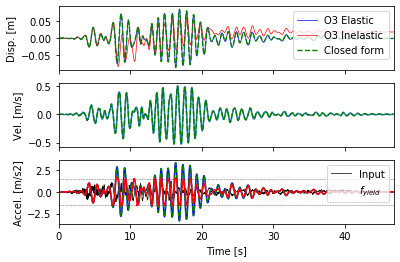

In [26]:
bf, sps = plt.subplots(nrows=3, sharex='col')
sps[0].plot(outputs_el["time"], outputs_el["rel_disp"], label='O3 Elastic', lw=0.7, c='b')
sps[0].plot(outputs_in["time"], outputs_in["rel_disp"], label='O3 Inelastic', lw=0.7, c='r')
sps[0].plot(time, resp_u[0], label='Closed form', lw=1.4, c='g', ls='--')
sps[1].plot(outputs_el["time"], outputs_el["rel_vel"])
sps[1].plot(time, resp_v[0], lw=1.4, c='g', ls='--')
sps[2].plot(time, acc_opensees_el, c='b')
sps[2].plot(time, resp_a[0], lw=1.4, c='g', ls='--')
sps[2].plot(time, acc_opensees_in, c='r')
sps[2].plot(time, rec, lw=0.7, c='k', label='Input', zorder=0)
sps[2].axhline(f_yield, c=(0.4, 0.4, 0.4), label='$f_{yield}$', ls='--', lw=0.5, zorder=-1)
sps[2].axhline(-f_yield, c=(0.4, 0.4, 0.4), ls='--', lw=0.5, zorder=-1)
sps[0].set_ylabel('Disp. [m]')
sps[1].set_ylabel('Vel. [m/s]')
sps[2].set_ylabel('Accel. [m/s2]')
sps[-1].set_xlabel('Time [s]')
sps[-1].set_xlim([0, time[-1]])
sps[0].legend(loc='upper right')
sps[2].legend(loc='upper right')
plt.show()